<a href="https://colab.research.google.com/github/zhang-linnng/convex_restriction_transformed/blob/main/updated0910Cost_projection_convexRestriction_case123nick.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!apt-get install -y -qq glpk-utils
!apt-get install -y -qq libglpk-dev
!pip install cvxpy

In [3]:
!pip install pypower

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.0/347.0 kB 4.7 MB/s eta 0:00:00


In [67]:
%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

In [68]:
!ipopt --version

Ipopt 3.13.2 (x86_64-pc-linux-gnu), ASL(20190605)



In [69]:
!which ipopt

bin/ipopt


# Import libraries

In [4]:
from __future__ import division
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import csv
from mpl_toolkits.mplot3d import Axes3D
import random
import pandas as pd
import math
import json
import pickle
import cmath
import sys

random.seed(1234321)

# Project folder

In [5]:
def create_dir(path):
    isExist = os.path.exists(path)

    if not isExist:
        # Create a new directory if it does not exist
        os.makedirs(path)
        print("The new directory %s is created!" % (path))

In [6]:
project_path = "/content/gdrive/MyDrive/2023Projects/convex_restriction/case123nick/"
ourMethod_path = project_path  + "our_method/"
socp_path = project_path  + "socp/"
se_proposed_path = project_path  + "proposed_state_estimation/"
# sdp_path = project_path  + "sdp/"
newtonRaphson_path = project_path  + "newton_raphson/"
settings_path = project_path + "grid_case123nick/"

In [7]:
create_dir(settings_path)
create_dir(ourMethod_path)
create_dir(socp_path)
create_dir(se_proposed_path)
create_dir(newtonRaphson_path)

The new directory /content/gdrive/MyDrive/2023Projects/convex_restriction/case123nick/proposed_state_estimation/ is created!


# Grid representation

## Parameters

In [8]:
import scipy.io as sio

# mat_contents = sio.loadmat(settings_path + mat_fname)
branch_contents = sio.loadmat(settings_path + 'branch_case123nick.mat')
bus_contents = sio.loadmat(settings_path + 'bus_case123nick.mat')
gen_contents = sio.loadmat(settings_path + 'gen_case123nick.mat')

print(branch_contents.keys())
print(bus_contents.keys())
print(gen_contents.keys())

dict_keys(['__header__', '__version__', '__globals__', 'branch'])
dict_keys(['__header__', '__version__', '__globals__', 'bus'])
dict_keys(['__header__', '__version__', '__globals__', 'gen'])


In [9]:
## branch data: fbus(0), tbus(1), r(2), x(3), b(4)
## bus data: bus(0), type(1), Pd(2), Qd(3), Vmx(11), Vmn(12)
## gen data: bus(0), Pg(1), Qg(2), Qmax(3), Qmin(4), Pmax(8), Pmin(9)

branch_data = branch_contents['branch']
bus_data = bus_contents['bus']
gen_data = gen_contents['gen']

branch_array = np.concatenate([branch_data[:,0:1], branch_data[:,1:2], branch_data[:,2:3], branch_data[:,3:4], branch_data[:,4:5]], axis=1)
branch_df = pd.DataFrame(branch_array, columns = ['fbus','tbus','r','x','b'])
branch_df['fbus'] = branch_df['fbus'].apply(lambda x: int(x))
branch_df['tbus'] = branch_df['tbus'].apply(lambda x: int(x))

bus_array = np.concatenate([bus_data[:,0:1], bus_data[:,1:2], bus_data[:,2:3], bus_data[:,3:4], bus_data[:,11:12], bus_data[:,12:13]], axis=1)
bus_df = pd.DataFrame(bus_array, columns = ['bus','type','Pd','Qd','Vmx','Vmn'])
bus_df['bus'] = bus_df['bus'].apply(lambda x: int(x))
bus_df['type'] = bus_df['type'].apply(lambda x: int(x))

gen_array = np.concatenate([gen_data[:,0:1], gen_data[:,1:2], gen_data[:,2:3], gen_data[:,3:4], gen_data[:,4:5], gen_data[:,8:9], gen_data[:,9:10]], axis=1)
gen_df = pd.DataFrame(gen_array, columns = ['bus','Pg','Qg','Qmax','Qmin','Pmax','Pmin'])
gen_df['bus'] = gen_df['bus'].apply(lambda x: int(x))

In [10]:
branch_df = branch_df.sort_values(by=['fbus', 'tbus'], ascending=True)

In [11]:
branch_df.head()

,fbus,tbus,r,x,b
0,1,2,0.002546,0.002581,0.000003
1,1,3,0.003637,0.003687,0.000004
2,1,7,0.001502,0.003539,0.000006
3,3,4,0.002909,0.002949,0.000003
4,3,5,0.004728,0.004793,0.000005


In [12]:
gen_df.head()

,bus,Pg,Qg,Qmax,Qmin,Pmax,Pmin
0,114,0,0,200,-200,200,-200


In [13]:
bus_df.head()

,bus,type,Pd,Qd,Vmx,Vmn
0,1,1,0.04,0.02,1.2,0.8
1,2,1,0.02,0.01,1.2,0.8
2,3,1,0.00,0.00,1.2,0.8
3,4,1,0.04,0.02,1.2,0.8
4,5,1,0.02,0.01,1.2,0.8


In [14]:
r_ij = branch_df["r"].to_numpy()
x_ij = branch_df["x"].to_numpy()
g_ij = r_ij/(r_ij**2+x_ij**2)
b_ij = x_ij/(r_ij**2+x_ij**2)
branch_df["conductance(g)"] = g_ij
branch_df["susceptance(b)"] = b_ij
branch_df.head()

,fbus,tbus,r,x,b,conductance(g),susceptance(b)
0,1,2,0.002546,0.002581,0.000003,193.723868,196.391040
1,1,3,0.003637,0.003687,0.000004,135.606729,137.473712
2,1,7,0.001502,0.003539,0.000006,101.623767,239.402135
3,3,4,0.002909,0.002949,0.000003,169.508376,171.842151
4,3,5,0.004728,0.004793,0.000005,104.312855,105.749003


In [15]:
count_lines_df = branch_df.groupby(['fbus', 'tbus']).count()
count_lines_df.head()
branches = count_lines_df.index.to_list()
branches_list = [(int(x[0]), int(x[1])) for x in branches]
print(branches_list)

nodes = bus_df['bus'].to_list()
nodes_list = [int(x) for x in nodes]
print(nodes_list)

num_nodes = len(nodes_list)
num_branches = len(branches_list)
print('num_nodes:', num_nodes)
print('num_branches:', num_branches)

[(1, 2), (1, 3), (1, 7), (3, 4), (3, 5), (5, 6), (7, 8), (8, 9), (8, 12), (8, 13), (9, 14), (13, 18), (13, 34), (13, 52), (14, 10), (14, 11), (15, 16), (15, 17), (18, 19), (18, 21), (18, 35), (19, 20), (21, 22), (21, 23), (23, 24), (23, 25), (25, 26), (25, 28), (26, 27), (26, 31), (27, 33), (28, 29), (29, 30), (31, 32), (34, 15), (35, 36), (35, 40), (36, 37), (36, 38), (38, 39), (40, 41), (40, 42), (42, 43), (42, 44), (44, 45), (44, 47), (45, 46), (47, 48), (47, 49), (49, 50), (50, 51), (52, 53), (53, 54), (54, 55), (54, 57), (55, 56), (57, 58), (57, 60), (58, 59), (60, 62), (60, 67), (62, 63), (63, 64), (64, 65), (65, 66), (67, 68), (67, 72), (67, 97), (68, 69), (69, 70), (70, 71), (72, 73), (72, 76), (73, 74), (74, 75), (76, 77), (76, 86), (77, 78), (78, 79), (78, 80), (80, 81), (81, 82), (81, 84), (82, 83), (84, 85), (86, 87), (87, 88), (87, 89), (89, 90), (89, 91), (91, 92), (91, 93), (93, 94), (93, 95), (95, 96), (97, 98), (97, 101), (98, 99), (99, 100), (101, 102), (101, 105), (1

In [73]:
numeric_to_bus = dict()
for idx, bus_name in enumerate(bus_df['bus'].tolist()):

    numeric_to_bus[idx] = bus_name
print(numeric_to_bus)

bus_to_numeric = dict()
for k in range(num_nodes):
    node_idx = nodes_list[k]
    bus_to_numeric[node_idx] = k

bus_to_neighbors = dict()
for edge in branches_list:
    fbus = edge[0]
    tbus = edge[1]
    if fbus not in bus_to_neighbors.keys():
        bus_to_neighbors[fbus] = [tbus]
    else:
        bus_to_neighbors[fbus] += [tbus]

    if tbus not in bus_to_neighbors.keys():
        bus_to_neighbors[tbus] = [fbus]
    else:
        bus_to_neighbors[tbus] += [fbus]

print('bus_to_numeric:', bus_to_numeric)
print('bus_to_neighbors:', bus_to_neighbors)


{0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 10, 10: 11, 11: 12, 12: 13, 13: 14, 14: 15, 15: 16, 16: 17, 17: 18, 18: 19, 19: 20, 20: 21, 21: 22, 22: 23, 23: 24, 24: 25, 25: 26, 26: 27, 27: 28, 28: 29, 29: 30, 30: 31, 31: 32, 32: 33, 33: 34, 34: 35, 35: 36, 36: 37, 37: 38, 38: 39, 39: 40, 40: 41, 41: 42, 42: 43, 43: 44, 44: 45, 45: 46, 46: 47, 47: 48, 48: 49, 49: 50, 50: 51, 51: 52, 52: 53, 53: 54, 54: 55, 55: 56, 56: 57, 57: 58, 58: 59, 59: 60, 60: 61, 61: 62, 62: 63, 63: 64, 64: 65, 65: 66, 66: 67, 67: 68, 68: 69, 69: 70, 70: 71, 71: 72, 72: 73, 73: 74, 74: 75, 75: 76, 76: 77, 77: 78, 78: 79, 79: 80, 80: 81, 81: 82, 82: 83, 83: 84, 84: 85, 85: 86, 86: 87, 87: 88, 88: 89, 89: 90, 90: 91, 91: 92, 92: 93, 93: 94, 94: 95, 95: 96, 96: 97, 97: 98, 98: 99, 99: 100, 100: 101, 101: 102, 102: 103, 103: 104, 104: 105, 105: 106, 106: 107, 107: 108, 108: 109, 109: 110, 110: 111, 111: 112, 112: 113, 113: 114}
bus_to_numeric: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9,

In [17]:
numbering_links = dict()
for i in range(num_branches):
    fbus = branch_df.iloc[i, 0]
    tbus = branch_df.iloc[i, 1]
    numbering_links[i] = (fbus, tbus)
print('numbering_links:', numbering_links)

numbering_links: {0: (1, 2), 1: (1, 3), 2: (1, 7), 3: (3, 4), 4: (3, 5), 5: (5, 6), 6: (7, 8), 7: (8, 9), 8: (8, 12), 9: (8, 13), 10: (9, 14), 11: (13, 18), 12: (13, 34), 13: (13, 52), 14: (14, 10), 15: (14, 11), 16: (15, 16), 17: (15, 17), 18: (18, 19), 19: (18, 21), 20: (18, 35), 21: (19, 20), 22: (21, 22), 23: (21, 23), 24: (23, 24), 25: (23, 25), 26: (25, 26), 27: (25, 28), 28: (26, 27), 29: (26, 31), 30: (27, 33), 31: (28, 29), 32: (29, 30), 33: (31, 32), 34: (34, 15), 35: (35, 36), 36: (35, 40), 37: (36, 37), 38: (36, 38), 39: (38, 39), 40: (40, 41), 41: (40, 42), 42: (42, 43), 43: (42, 44), 44: (44, 45), 45: (44, 47), 46: (45, 46), 47: (47, 48), 48: (47, 49), 49: (49, 50), 50: (50, 51), 51: (52, 53), 52: (53, 54), 53: (54, 55), 54: (54, 57), 55: (55, 56), 56: (57, 58), 57: (57, 60), 58: (58, 59), 59: (60, 62), 60: (60, 67), 61: (62, 63), 62: (63, 64), 63: (64, 65), 64: (65, 66), 65: (67, 68), 66: (67, 72), 67: (67, 97), 68: (68, 69), 69: (69, 70), 70: (70, 71), 71: (72, 73), 72:

In [18]:
# incidence matrix
E = np.zeros((num_branches, num_nodes))
for m in range(num_branches):
    f_end = branch_df.iloc[m, 0]
    t_end = branch_df.iloc[m, 1]

    col1 = bus_to_numeric[f_end]
    col2 = bus_to_numeric[t_end]

    if col1 < col2:
        E[m, col1] = 1
        E[m, col2] = -1
    else:
        E[m, col1] = -1
        E[m, col2] = 1

print('E:', E)

E: [[ 1. -1.  0. ...  0.  0.  0.]
 [ 1.  0. -1. ...  0.  0.  0.]
 [ 1.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1. -1.  0.]
 [ 0.  0.  0. ...  0. -1.  0.]
 [ 1.  0.  0. ...  0.  0. -1.]]


In [19]:
gen_set_mask = bus_df['type']>1
gen_set = bus_df['bus'][gen_set_mask]
gen_rows = np.array(range(num_nodes))[gen_set_mask]
print('gen_set:\n', gen_set)
print('gen_rows:\n', gen_rows)

gen_set:
 113    114
Name: bus, dtype: int64
gen_rows:
 [113]


In [20]:
bus_lists = bus_df['bus'].to_numpy()
print(bus_lists.shape)
print(bus_lists)

(114,)
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114]


In [21]:
branch_df['index'] = branch_df.index
branch_df.head()

b_for_lines = b_ij.reshape(-1,1)
g_for_lines = g_ij.reshape(-1,1)

##  Vectorize power flow equations

### Define matrices

In [22]:
G_a = np.zeros((num_nodes, num_branches))
for row in range(num_nodes):
    for col in range(num_branches):
        row_bus = bus_df['bus'].iloc[row]
        end1 = branch_df.iloc[col, 0]
        end2 = branch_df.iloc[col, 1]
        edge = (end1, end2)

        if row_bus not in edge:
            G_a[row, col] = 0

        else: # if bus in edge
            if edge[0] == row_bus:
                neighbor = edge[1]
            else:
                neighbor = edge[0]

            # convert bus no. to numerical indexes
            neighbor_idx = bus_to_numeric[neighbor]


            if row > neighbor_idx: # if row > neighbor
                G_a[row, col] = -g_ij[col]

            else: # if row < neighbor
                G_a[row, col] = -g_ij[col]


B_a = np.zeros((num_nodes, num_branches))
for row in range(num_nodes):
    for col in range(num_branches):
        row_bus = bus_df['bus'].iloc[row]
        end1 = branch_df.iloc[col, 0]
        end2 = branch_df.iloc[col, 1]
        edge = (end1, end2)

        if row_bus not in edge:
            B_a[row, col] = 0

        else: # if bus in edge
            if edge[0] == row_bus:
                neighbor = edge[1]
            else:
                neighbor = edge[0]

            # convert bus no. to numerical indexes
            neighbor_idx = bus_to_numeric[neighbor]

            if row > neighbor_idx: # if row > neighbor
                B_a[row, col] = -b_ij[col]

            else: # if row < neighbor
                B_a[row, col] = b_ij[col]


print('G_a:', G_a.shape)
print('B_a:', B_a.shape)

G_hat = np.zeros((num_nodes, num_nodes))
for m in range(num_branches):
    end1 = branch_df.iloc[m, 0]
    end2 = branch_df.iloc[m, 1]

    row = bus_to_numeric[end1]
    col = bus_to_numeric[end2]

    G_hat[row, col] = g_ij[m]
    G_hat[col, row] = g_ij[m]

print('G_hat:', G_hat.shape)


d_active = np.zeros((num_nodes, 1))
for row in range(num_nodes):

    d_active[row, 0] = np.sum(G_hat[row,:])

print('d_active:', d_active.shape)

A = np.block([
    G_a, B_a, d_active
])
print('A:', A.shape)

G_a: (114, 113)
B_a: (114, 113)
G_hat: (114, 114)
d_active: (114, 1)
A: (114, 227)


In [23]:
G_r = np.zeros((num_nodes, num_branches))
for row in range(num_nodes):
    for col in range(num_branches):
        row_bus = bus_df['bus'].iloc[row]
        end1 = branch_df.iloc[col, 0]
        end2 = branch_df.iloc[col, 1]
        edge = (end1, end2)

        if row_bus not in edge:
            G_r[row, col] = 0

        else: # if bus in edge
            if edge[0] == row_bus:
                neighbor = edge[1]
            else:
                neighbor = edge[0]

            # convert bus no. to numerical indexes
            neighbor_idx = bus_to_numeric[neighbor]


            if row > neighbor_idx: # if row > neighbor
                G_r[row, col] = g_ij[col]

            else: # if row < neighbor
                G_r[row, col] = -g_ij[col]


B_r = np.zeros((num_nodes, num_branches))
for row in range(num_nodes):
    for col in range(num_branches):
        row_bus = bus_df['bus'].iloc[row]
        end1 = branch_df.iloc[col, 0]
        end2 = branch_df.iloc[col, 1]
        edge = (end1, end2)

        if row_bus not in edge:
            B_r[row, col] = 0

        else: # if bus in edge
            if edge[0] == row_bus:
                neighbor = edge[1]
            else:
                neighbor = edge[0]

            # convert bus no. to numerical indexes
            neighbor_idx = bus_to_numeric[neighbor]

            if row > neighbor_idx: # if row > neighbor
                B_r[row, col] = -b_ij[col]

            else: # if row < neighbor
                B_r[row, col] = -b_ij[col]


print('G_r:', G_r.shape)
print('B_r:', B_r.shape)


B_hat = np.zeros((num_nodes, num_nodes))
for m in range(num_branches):
    end1 = branch_df.iloc[m, 0]
    end2 = branch_df.iloc[m, 1]

    row = bus_to_numeric[end1]
    col = bus_to_numeric[end2]

    B_hat[row, col] = b_ij[m]
    B_hat[col, row] = b_ij[m]

print('B_hat:', B_hat.shape)

d_reactive = np.zeros((num_nodes, 1))
for row in range(num_nodes):

    d_reactive[row, 0] = np.sum(B_hat[row,:])

print('d_reactive:', d_reactive.shape)

R = np.block([
    B_r, G_r, d_reactive
])
print('R:', R.shape)

G_r: (114, 113)
B_r: (114, 113)
B_hat: (114, 114)
d_reactive: (114, 1)
R: (114, 227)


### Power flow equations

In [24]:
def p_in_voltage(theta):

    x = theta.reshape(-1,1)
    z = np.sin(E@x)

    return G_a @ np.sqrt(1-z**2) + B_a @ z + d_active


def q_in_voltage(theta):

    x = theta.reshape(-1,1)
    z = np.sin(E@x)

    return B_r @ np.sqrt(1-z**2) + G_r @ z + d_reactive

nominal_angle = np.zeros(num_nodes)
p = p_in_voltage(nominal_angle)
q = q_in_voltage(nominal_angle)
print(p)
print(q)

[[ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-5.68434189e-14]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-2.84217094e-14]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.0000000

## Active and reactive demands

In [25]:
bus_df['Pd'] = bus_df['Pd'] * 10
bus_df['Qd'] = bus_df['Qd'] * 10

## Nodal power bounds

In [26]:
bus_df['Pmax'] = bus_df['bus']
bus_df['Pmin'] = bus_df['Pd']
bus_df['Qmax'] = bus_df['Pd']
bus_df['Qmin'] = bus_df['Pd']
bus_df.head()

,bus,type,Pd,Qd,Vmx,Vmn,Pmax,Pmin,Qmax,Qmin
0,1,1,0.4,0.2,1.2,0.8,1,0.4,0.4,0.4
1,2,1,0.2,0.1,1.2,0.8,2,0.2,0.2,0.2
2,3,1,0.0,0.0,1.2,0.8,3,0.0,0.0,0.0
3,4,1,0.4,0.2,1.2,0.8,4,0.4,0.4,0.4
4,5,1,0.2,0.1,1.2,0.8,5,0.2,0.2,0.2


In [27]:
gen_df_copy = gen_df.copy()
gen_df_copy = gen_df_copy.set_index('bus')
gen_df_copy.head()

,Pg,Qg,Qmax,Qmin,Pmax,Pmin
bus,,,,,,
114,0,0,200,-200,200,-200


In [28]:
for i in range(num_nodes):
    bus = bus_df.iloc[i, 0]
    type = bus_df.iloc[i, 1]
    if type > 1: # generator or slack(reference) buses, copy everything
        bus_df.loc[i, 'Pmax']= gen_df_copy.loc[bus, 'Pmax']
        # bus_df.loc[i, 'Pmin']= gen_df_copy.loc[bus, 'Pmin']
        bus_df.loc[i, 'Pmin']= 0
        bus_df.loc[i, 'Qmax']= gen_df_copy.loc[bus, 'Qmax']
        bus_df.loc[i, 'Qmin']= gen_df_copy.loc[bus, 'Qmin']

    else:
       # load buses, Pmax = -Pd; Pmin

        bus_df.loc[i, 'Pmax'] = -bus_df['Pd'][i]
        bus_df.loc[i, 'Pmin'] = -10. # set a maximum loading at this bus,
        # based on the generators's capacity, which is 10, I set the maximum loading to be 10

        # # this results in infeasibility
        # bus_df.loc[i, 'Qmax'] = bus_df['Qd'][i] # positive Qmax means maximum reactive power that
        # # this load bus can consume
        # bus_df.loc[i, 'Qmin'] = 0. # postive Q min means that this load bus cannot contribute(generate)
        # # reactive power
        bus_df.loc[i, 'Qmax'] = 10. # this is the maximum reactive power that generator bus can contribute
        bus_df.loc[i, 'Qmin'] = bus_df['Qd'][i]


bus_df.head()

,bus,type,Pd,Qd,Vmx,Vmn,Pmax,Pmin,Qmax,Qmin
0,1,1,0.4,0.2,1.2,0.8,-0.4,-10.0,10.0,0.2
1,2,1,0.2,0.1,1.2,0.8,-0.2,-10.0,10.0,0.1
2,3,1,0.0,0.0,1.2,0.8,-0.0,-10.0,10.0,0.0
3,4,1,0.4,0.2,1.2,0.8,-0.4,-10.0,10.0,0.2
4,5,1,0.2,0.1,1.2,0.8,-0.2,-10.0,10.0,0.1


In [29]:
Qmax = bus_df['Qmax'].to_numpy()
# Qmin = bus_df['Qmin'].to_numpy()
# Pmax = bus_df['Pmax'].to_numpy()
Pmin = bus_df['Pmin'].to_numpy()
print('Qmax shape:', Qmax.shape)

Qmax shape: (114,)


In [30]:
# Load the dictionary from the pickle file
with open(project_path + 'modification_file.pkl', 'rb') as file:
    modification_file = pickle.load(file)

# print("modification_file:", modification_file)


In [31]:
Qmin = modification_file['new_q_min']
Pmax = modification_file['new_p_max']
# INTERIOR_Z = modification_file['z_interior']

In [32]:
bus_types = []
for i in range(num_nodes):
    match bus_df.iloc[i,1]:
        case 1:
            # print('PQ bus')
            bus_types.append('load')
        case 2:
            # print('PV bus')
            bus_types.append('gen')
        case 3:
            # print('reference bus')
            bus_types.append('slack')
        case _:
            # print('Isolated bus')
            bus_types.append('isolated')

print('bus types:', bus_types)

bus types: ['load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'slack']


# Our method

## Power flow equations using cp functions

In [33]:
import cvxpy as cp

In [34]:
print('G_a:', G_a.shape)
print('B_a:', B_a.shape)
print('d_active:', d_active.shape)

print('G_r:', G_r.shape)
print('B_r:', B_r.shape)
print('d_reactive:', d_reactive.shape)

G_a: (114, 113)
B_a: (114, 113)
d_active: (114, 1)
G_r: (114, 113)
B_r: (114, 113)
d_reactive: (114, 1)


In [35]:
bus_df.head()

,bus,type,Pd,Qd,Vmx,Vmn,Pmax,Pmin,Qmax,Qmin
0,1,1,0.4,0.2,1.2,0.8,-0.4,-10.0,10.0,0.2
1,2,1,0.2,0.1,1.2,0.8,-0.2,-10.0,10.0,0.1
2,3,1,0.0,0.0,1.2,0.8,-0.0,-10.0,10.0,0.0
3,4,1,0.4,0.2,1.2,0.8,-0.4,-10.0,10.0,0.2
4,5,1,0.2,0.1,1.2,0.8,-0.2,-10.0,10.0,0.1


In [36]:
branch_df.head()

,fbus,tbus,r,x,b,conductance(g),susceptance(b),index
0,1,2,0.002546,0.002581,0.000003,193.723868,196.391040,0
1,1,3,0.003637,0.003687,0.000004,135.606729,137.473712,1
2,1,7,0.001502,0.003539,0.000006,101.623767,239.402135,2
3,3,4,0.002909,0.002949,0.000003,169.508376,171.842151,3
4,3,5,0.004728,0.004793,0.000005,104.312855,105.749003,4


In [37]:
def cp_p_in_transformed_space(z):

    return G_a @ cp.sqrt(1-cp.square(z)) + B_a @ z + d_active

def cp_q_in_transformed_space(z):

    return B_r @ cp.sqrt(1-cp.square(z)) + G_r @ z + d_reactive


def p_in_transformed_space(z):

    z = z.reshape(-1, 1)

    return G_a @ np.sqrt(1-z**2) + B_a @ z + d_active


def q_in_transformed_space(z):

    z = z.reshape(-1, 1)

    return B_r @ np.sqrt(1-z**2) + G_r @ z + d_reactive

def recover_phase_angle(z):
    z = np.squeeze(z)

    all_edges = branch_df[['fbus', 'tbus']].values
    recovered = dict()
    for row in bus_df['bus'].values:
        recovered[row] = 0.

    for i, row in enumerate(all_edges):
        print("The edge is: {}, and the angle difference is: {}".format(row, np.arcsin(z[i])))
        node1 = row[0]
        node2 = row[1]
        if node1 < node2:
            recovered[node2] = recovered[node1] - np.arcsin(z[i])
        else:
            recovered[node1] = recovered[node2] - np.arcsin(z[i])

    x = list(recovered.values())
    print('recovered values:', recovered)

    return recovered

In [38]:
from scipy.optimize import fsolve
# scipy.optimize.fsolve(func, x0)
# func : callable f(x, *args)
# func can be vector function
# find the roots of the (non-linear) equations defined by func(x) = 0 given a starting estimate.
# def func(x):
#     return [x[0] * np.cos(x[1]) - 4,
#             x[1] * x[0] - x[1] - 5]
# root = fsolve(func=func, x0=[1, 1])

# np.isclose(func(root), [0.0, 0.0])  # func(root) should be almost 0.0.


## Check solution feasibility

In [39]:
# check if origin is a feasible point
def is_voltage_feasible(theta):

    p = p_in_voltage(theta)
    q = q_in_voltage(theta)

    # print('p_max:\n', np.squeeze(Pmax))
    # print('p:\n', np.squeeze(p))
    # print('p_min:\n', np.squeeze(Pmin))

    # print('q_max:\n', np.squeeze(Qmax))
    # print('q:\n', np.squeeze(q))
    # print('q_min:\n', np.squeeze(Qmin))

    p_values = np.squeeze(p)
    q_values = np.squeeze(q)

    tolerance = -1e-6

    # if np.all(p_values>=Pmin) & np.all(p_values<=Pmax) & np.all(q_values >=Qmin) & np.all(q_values<=Qmax):
    if np.all(p_values-Pmin>=tolerance) & np.all(Pmax-p_values>=tolerance) & np.all(q_values-Qmin>=tolerance) & np.all(Qmax-q_values>=tolerance):

        return True
    else:
        return False


nominal_angle = np.zeros(num_nodes)
is_voltage_feasible(nominal_angle) # Nooope


False

In [40]:
def is_z_feasible(z):

    p = p_in_transformed_space(z)
    q = q_in_transformed_space(z)

    # print('p_max:\n', np.squeeze(Pmax))
    # print('p:\n', np.squeeze(p))
    # print('p_min:\n', np.squeeze(Pmin))

    # print('q_max:\n', np.squeeze(Qmax))
    # print('q:\n', np.squeeze(q))
    # print('q_min:\n', np.squeeze(Qmin))


    p_values = np.squeeze(p)
    q_values = np.squeeze(q)
    # print('p1-p1_max:',p_values[0]-Pmax[0])
    # print('p2-p2_max:',p_values[1]-Pmax[1])
    # print('p3-p3_max:',p_values[2]-Pmax[2])
    # print('p400-p400_max:',p_values[3]-Pmax[3])


    # print('p>=Pmin?',np.all(p_values>=Pmin))
    # print('p<=Pmax?',np.all(p_values<=Pmax))
    # print('q>=Qmin?',np.all(q_values>=Qmin))
    # print('q<=Qmax?',np.all(q_values<=Qmax))
    # print('p-Pmin:',p_values-Pmin)
    # print('Pmax-p:',Pmax-p_values)
    # print('q-Qmin:',q_values-Qmin)
    # print('Qmax-q:',Qmax-q_values)

    tolerance = -1e-6

    # if np.all(p_values>=Pmin) & np.all(p_values<=Pmax) & np.all(q_values >=Qmin) & np.all(q_values<=Qmax):
    if np.all(p_values-Pmin>=tolerance) & np.all(Pmax-p_values>=tolerance) & np.all(q_values-Qmin>=tolerance) & np.all(Qmax-q_values>=tolerance):

        return True
    else:
        return False


nominal_z = np.zeros(num_branches)
is_z_feasible(nominal_z)

False

## Input an interior point

In [161]:
# INTERIOR_Z = np.load(project_path + 'base_case/iter6_z_solution.npy')

# INTERIOR_Z = modification_file['z_interior']

INTERIOR_Z = np.load(se_proposed_path + 'iter2_z_solution.npy')

print('is it feasible?', is_z_feasible(INTERIOR_Z))
z_interior = INTERIOR_Z

is it feasible? True


## Generate cost coefficients

In [162]:
random.seed(178987)

cost_coefficients_list = []
count_distributed_gen = 0
distributed_gen_list = []

for i in range(num_nodes):
    Pi_max = Pmax[i]
    # Qi_min = Qmin[i]
    if Pi_max <= 0: # a load
        cost_coefficients_list.append(-np.random.randint(1, num_nodes))
    else: # a generator
        cost_coefficients_list.append(np.random.randint(1, num_nodes))
        count_distributed_gen+=1
        distributed_gen_list.append(bus_df.loc[i,'bus'])

print(len(cost_coefficients_list))
print(cost_coefficients_list[:10])
print(count_distributed_gen)
print(distributed_gen_list)

114
[67, -75, 109, -13, -55, -110, 91, 19, -13, -63]
32
[1, 3, 7, 8, 13, 14, 15, 18, 21, 23, 25, 26, 27, 36, 40, 44, 52, 54, 57, 67, 72, 78, 81, 89, 91, 93, 97, 101, 105, 108, 110, 114]


In [163]:
buscost = np.array(cost_coefficients_list)/20
np.save(project_path + 'buscost.npy', buscost)
np.save(project_path + 'distributed_gen_list.npy', distributed_gen_list)

In [164]:
# dc_va_contents = sio.loadmat(project_path + 'case123nick_voltage_angles.mat')
# print(dc_va_contents.keys())

# dc_va_degrees = dc_va_contents['voltage_angles']
# print('dc_va shape:', dc_va_degrees.shape)
# print('dc_va:', np.squeeze(dc_va_degrees))

# dc_va_radian = dc_va_degrees / 180 * np.pi
# transfom_to_z =  np.sin(E @ dc_va_radian) * 15
# print('transfom_to_z:', np.squeeze(transfom_to_z))

# candidate_z_values = np.squeeze(transfom_to_z).tolist()
# candidate_z_values = [np.round(x, 4) for x in candidate_z_values]
# print('candidate_z_values:', candidate_z_values)

# z_values = np.array(candidate_z_values)
# print('is it feasible?', is_z_feasible(z_values))

# nominal_p = p_in_transformed_space(z_values)
# nominal_q = q_in_transformed_space(z_values)

# p_max = Pmax.reshape(-1, 1)
# p_min = Pmin.reshape(-1, 1)
# q_max = Qmax.reshape(-1, 1)
# q_min = Qmin.reshape(-1, 1)
# nominal_p = np.array(nominal_p).reshape(-1, 1)
# nominal_q = np.array(nominal_q).reshape(-1, 1)
# bus_types = np.array(bus_types).reshape(-1, 1)

# results = np.concatenate([bus_types, p_max, nominal_p, p_min, q_max, nominal_q, q_min], axis=1)
# column_names = ['bus_types', 'p_max', 'nominal_p', 'p_min', 'q_max', 'nominal_q', 'q_min']
# results_df = pd.DataFrame(results, columns=column_names)
# print(results_df)

In [165]:
# new_p_max = np.maximum(np.squeeze(p_max), np.squeeze(nominal_p))
# new_q_min = np.minimum(np.squeeze(q_min), np.squeeze(nominal_q))

In [166]:
# new_p_max = [np.round(x, 4)+0.01 for x in new_p_max]
# print(new_p_max)
# new_q_min = [np.round(x, 4)-0.01 for x in new_q_min]
# print(new_q_min)
# new_p_max[0] = 10
# new_q_min[0] = -10

In [167]:
# import pickle
# modification = dict()
# modification['new_p_max'] = np.array(new_p_max)
# modification['new_q_min'] = np.array(new_q_min)
# modification['z_interior'] = z_values

# # Save the dictionary to the pickle file
# with open(project_path + 'modification_file.pkl', 'wb') as file:
#     pickle.dump(modification, file)

## Linearize nodal power

### Meta functions

In [168]:
def root_of_quadratic_equation(params):
    a = params['a']
    b = params['b']
    c = params['c']

    A = a**2 + b**2
    B = 2*b*c
    C = c**2 - a**2

    # discriminant is denoted by D
    D = B**2 - 4*A*C

    if np.isclose(D, 0.0, atol=1e-9):# this equation has a single real root

        root = (-B)/(2*A)

        return [root], 1

    elif D > 0.0: # this equation has two distinct real roots

        # find two solutions
        sol1 = (-B-cmath.sqrt(D))/(2*A)
        sol2 = (-B+cmath.sqrt(D))/(2*A)

        root1 = sol1.real
        root2 = sol2.real

        return sorted([root1, root2], reverse=True), 2

    else: # D<0.0 and this equation has no real root

        return None, 0

def f_prime(x):

    return -x/np.sqrt(1-x**2)


def Jacobian(z):
    z = np.squeeze(z)

    return np.diag(f_prime(z))


def linearize_Pi(bus_i, z_base, z):
    z_base = z_base.reshape(-1,1)

    G_a_rowi = G_a[bus_i,:].reshape(1,-1)
    B_a_rowi = B_a[bus_i,:].reshape(1,-1)

    Pi_z_base = G_a_rowi @ np.sqrt(1-z_base**2) + B_a_rowi @ z_base + d_active[bus_i,0]
    Pi_z_base = Pi_z_base[0,0]

    dp_dz_base = G_a_rowi @ Jacobian(z_base) + B_a_rowi # a row vector
    # print('dp_dz_base:', dp_dz_base.shape)
    linearization = Pi_z_base + dp_dz_base @ (z-z_base)
    # print('linearization:', linearization.shape)

    return linearization[0,0]


def linearize_Qi(bus_i, z_base, z):
    z_base = z_base.reshape(-1,1)

    B_r_rowi = B_r[bus_i,:].reshape(1,-1)
    G_r_rowi = G_r[bus_i,:].reshape(1,-1)

    Qi_z_base = B_r_rowi @ np.sqrt(1-z_base**2) + G_r_rowi @ z_base + d_reactive[bus_i,0]
    Qi_z_base = Qi_z_base[0,0]

    dq_dz_base = B_r_rowi @ Jacobian(z_base) + G_r_rowi # a row vector
    # print('dp_dz_base:', dp_dz_base.shape)
    linearization = Qi_z_base + dq_dz_base @ (z-z_base)
    # print('linearization:', linearization.shape)

    return linearization[0,0]


## Find base points for each lower bound constraint

### Find base points for Pi

In [169]:
def basePoint_of_Pi(bus_name, z_nominal):

    print('Linearize P{}...'.format(bus_name))
    print('An interior point is ', np.squeeze(z_nominal).tolist())

    z_nominal = z_nominal.reshape(-1, 1)

    bus_i = bus_to_numeric[bus_name]

    # variable
    z = cp.Variable(shape=(num_branches, 1))

    # objective
    minimal_distance = cp.norm(z-z_nominal, 2)

    # add constraints
    G_a_rowi = G_a[bus_i,:].reshape(1,-1)
    B_a_rowi = B_a[bus_i,:].reshape(1,-1)

    Pi_z = G_a_rowi @ cp.sqrt(1-cp.square(z)) + B_a_rowi @ z + d_active[bus_i,0]
    constraints = [ Pi_z <= Pmin[bus_i] ]

    problem = cp.Problem(cp.Minimize(minimal_distance), constraints)

    # Indicate the solver when solving the problem
    solver = cp.CVXOPT  # Replace with the solver of your choice
    problem.solve(solver=solver, ignore_dpp=True)

    if problem.status in ["infeasible", "unbounded"]:
        print(5*' ' +"Model not solved to (sub)optimality using CVXPY!!!")
        print(5*' ' +"Solver status: ", problem.status)
        # sys.exit(0)

        return None

    z_base = z.value
    Pi_z_base = G_a_rowi @ np.sqrt(1-z_base**2) + B_a_rowi @ z_base + d_active[bus_i,0]
    Pi_z_base = Pi_z_base[0,0]
    print(r'$P_i(z^{base})$:', Pi_z_base)
    print(r'$P_i^{\min}$:', Pmin[bus_i])


    return np.squeeze(z_base).tolist()


In [170]:
basePoint_of_Pi(3, z_interior)

Linearize P3...
An interior point is  [0.00046842536214823036, 0.003513584832367011, 0.11738924736979578, 0.001161583527180043, 0.002783447138902136, 0.0014566551973020968, 0.07781838393949561, 0.003131798955467605, 0.0006584998994720275, 0.1125731930058208, 0.0035490187384759194, 0.10528878469158816, 0.0022108684803895983, 0.09291187393605, -0.0006544695741892646, -0.0014423142798138792, 0.002200473490862622, 0.00100728208942684, 0.002929004499751881, 0.009594305933545672, 0.0329843037404127, 0.001923438522913327, 0.0031179826391893872, 0.006892099608681868, 0.003202271872835544, 0.006291781472306967, 0.0032781603323916793, 0.002805657258458921, 0.0013030527810027487, 0.0012881910848560633, 0.002917653112944654, 0.002808073838348838, 0.0016072905278660934, 0.0008960239831997947, -0.000902798770590332, 0.0061050333961686675, 0.01868595550712356, 0.0017808497507802834, 0.0015104523366670577, 0.001005249393951833, 0.0010008509225843218, 0.01808725175940449, 0.0029212066287032123, 0.01308

[0.0004684256738602224,
 0.02685717227360371,
 0.1173893260907979,
 -0.0279837689560763,
 -0.01538260728361626,
 0.0014566561666291957,
 0.07781843590347969,
 0.003131801039523748,
 0.0006585003376684995,
 0.11257326845225853,
 0.0035490211001748787,
 0.10528885519532559,
 0.0022108699516081767,
 0.09291193606814918,
 -0.0006544700097037691,
 -0.0014423152395978318,
 0.002200474955163834,
 0.0010072827597194366,
 0.0029290064488570215,
 0.009594312318384509,
 0.032984325703592686,
 0.0019234398028612537,
 0.0031179847140513557,
 0.006892104195131582,
 0.0032022740037884567,
 0.0062917856592467555,
 0.0032781625138452197,
 0.002805659125481907,
 0.0013030536481153376,
 0.0012881919420789617,
 0.0029176550544959424,
 0.002808075706979951,
 0.0016072915974333368,
 0.0008960245794559721,
 -0.0009027993713547733,
 0.006105037458829271,
 0.018685967944155946,
 0.0017808509358424607,
 0.0015104533417934051,
 0.0010052500628917774,
 0.0010008515885973144,
 0.01808726379779618,
 0.0029212085726

### Find base points for Qi

In [171]:
def basePoint_of_Qi(bus_name, z_nominal):
    print('Linearize Q{}...'.format(bus_name))
    print('An interior point is ', np.squeeze(z_nominal).tolist())

    z_nominal = z_nominal.reshape(-1, 1)

    bus_i = bus_to_numeric[bus_name]

    # variable
    z = cp.Variable(shape=(num_branches, 1))

    # objective
    minimal_distance = cp.norm(z-z_nominal, 2)

    # add constraints
    B_r_rowi = B_r[bus_i,:].reshape(1,-1)
    G_r_rowi = G_r[bus_i,:].reshape(1,-1)

    Qi_z = B_r_rowi @ cp.sqrt(1-cp.square(z)) + G_r_rowi @ z + d_reactive[bus_i,0]
    Qi_z = Qi_z[0,0]

    constraints = [ Qi_z <= Qmin[bus_i] ]

    problem = cp.Problem(cp.Minimize(minimal_distance), constraints)

    # Indicate the solver when solving the problem
    solver = cp.CVXOPT  # Replace with the solver of your choice
    problem.solve(solver=solver, ignore_dpp=True)

    if problem.status in ["infeasible", "unbounded"]:
        print(5*' ' +"Model not solved to (sub)optimality using CVXPY!!!")
        print(5*' ' +"Solver status: ", problem.status)
        # sys.exit(0)

        return None

    z_base = z.value
    Qi_z_base = B_r_rowi @ np.sqrt(1-z_base**2) + G_r_rowi @ z_base + d_reactive[bus_i,0]
    Qi_z_base = Qi_z_base[0,0]
    print(r'$Q_i(z^{base})$:', Qi_z_base)
    print(r'$Q_i^{\min}$:', Qmin[bus_i])


    return np.squeeze(z_base).tolist()


In [172]:
basePoint_of_Qi(2, z_interior)

Linearize Q2...
An interior point is  [0.00046842536214823036, 0.003513584832367011, 0.11738924736979578, 0.001161583527180043, 0.002783447138902136, 0.0014566551973020968, 0.07781838393949561, 0.003131798955467605, 0.0006584998994720275, 0.1125731930058208, 0.0035490187384759194, 0.10528878469158816, 0.0022108684803895983, 0.09291187393605, -0.0006544695741892646, -0.0014423142798138792, 0.002200473490862622, 0.00100728208942684, 0.002929004499751881, 0.009594305933545672, 0.0329843037404127, 0.001923438522913327, 0.0031179826391893872, 0.006892099608681868, 0.003202271872835544, 0.006291781472306967, 0.0032781603323916793, 0.002805657258458921, 0.0013030527810027487, 0.0012881910848560633, 0.002917653112944654, 0.002808073838348838, 0.0016072905278660934, 0.0008960239831997947, -0.000902798770590332, 0.0061050333961686675, 0.01868595550712356, 0.0017808497507802834, 0.0015104523366670577, 0.001005249393951833, 0.0010008509225843218, 0.01808725175940449, 0.0029212066287032123, 0.01308

[0.0004484746460092379,
 0.003513584866626473,
 0.1173892486191833,
 0.001161583538505319,
 0.0027834471660415083,
 0.001456655211504353,
 0.077818384728768,
 0.003131798986003921,
 0.0006584999058922698,
 0.11257319419587992,
 0.0035490187730809397,
 0.10528878579381756,
 0.002210868501945762,
 0.09291187489393608,
 -0.0006544695805702119,
 -0.0014423142938763088,
 0.002200473512317427,
 0.0010072820992476769,
 0.0029290045283106355,
 0.009594306027145208,
 0.03298430406432841,
 0.001923438541666875,
 0.0031179826695909713,
 0.006892099675899486,
 0.0032022719040590924,
 0.006291781533666543,
 0.003278160364355278,
 0.002805657285814871,
 0.0013030527937073595,
 0.001288191097415771,
 0.002917653141392716,
 0.0028080738657283526,
 0.0016072905435370786,
 0.0008960239919358707,
 -0.0009027987793924618,
 0.006105033455706098,
 0.018685955689730263,
 0.0017808497681435283,
 0.0015104523513938468,
 0.001005249403752851,
 0.001000850932342455,
 0.01808725193613461,
 0.0029212066571859263,


In [173]:
all_bus_names = bus_df['bus'].to_numpy()
print('all_bus_names:', all_bus_names)

Pi_basePoints = dict()
Qi_basePoints = dict()

for bus_name in all_bus_names:
    Pi_basePoints[bus_name] = basePoint_of_Pi(bus_name, z_interior)
    Qi_basePoints[bus_name] = basePoint_of_Qi(bus_name, z_interior)

print('Pi_basePoints:', Pi_basePoints)
print('Qi_basePoints:', Qi_basePoints)


all_bus_names: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114]
Linearize P1...
An interior point is  [0.00046842536214823036, 0.003513584832367011, 0.11738924736979578, 0.001161583527180043, 0.002783447138902136, 0.0014566551973020968, 0.07781838393949561, 0.003131798955467605, 0.0006584998994720275, 0.1125731930058208, 0.0035490187384759194, 0.10528878469158816, 0.0022108684803895983, 0.09291187393605, -0.0006544695741892646, -0.0014423142798138792, 0.002200473490862622, 0.00100728208942684, 0.002929004499751881, 0.009594305933545672, 0.0329843037404127, 0.001923438522913327, 

## Solve by CVXPY

In [174]:
# def our_method():

#     p_max = Pmax.reshape(-1, 1)
#     p_min = Pmin.reshape(-1, 1)
#     q_max = Qmax.reshape(-1, 1)
#     q_min = Qmin.reshape(-1, 1)

#     ## ------ CVXPY Environment: Define the problem ------ ##
#     # variables
#     # state = cp.Variable(shape=(2, 1), nonneg=True)
#     z = cp.Variable(shape=(num_branches, 1))

#     # expressions
#     p = cp_p_in_transformed_space(z)# active nodal power
#     q = cp_q_in_transformed_space(z)# reactive nodal power
#     # p_basePoint = get_p_basePoint()
#     # q_basePoint = get_q_basePoint()

#     # linearized_p = # linearize active nodal power function
#     # linearized_q = # linearize reactive nodal power function

#     # objective
#     # total_generation = cp.sum(p[gen_rows,:]) # sum of active nodal power at generators
#     total_losses = cp.sum(p) # total transmission losses

#     # constraints
#     constraints = [
#                     z >= -1,
#                     z <= 1,
#                     p <= p_max,
#                     q <= q_max
#     ]
#     # add linearized constraints
#     for bus_i, bus_name in enumerate(bus_lists):
#         # print('bus name is {}, index is {}'.format(bus_name, bus_i))
#         base_point = Pi_basePoints[bus_name]
#         if base_point is not None:
#             z_base = np.array(base_point).reshape(-1,1)
#             constraints += [linearize_Pi(bus_i, z_base, z)>=Pmin[bus_i]]

#     for bus_i, bus_name in enumerate(bus_lists):
#         base_point = Qi_basePoints[bus_name]
#         if base_point is not None:
#             z_base = np.array(base_point).reshape(-1,1)
#             constraints += [linearize_Qi(bus_i, z_base, z)>=Qmin[bus_i]]

#     problem = cp.Problem(cp.Minimize(total_losses), constraints)
#     # problem = cp.Problem(cp.Minimize(total_generation), constraints)

#     # problem.solve(ignore_dpp=True)

#     # Indicate the solver when solving the problem
#     solver = cp.CVXOPT  # Replace with the solver of your choice
#     problem.solve(solver=solver, ignore_dpp=True)

#     if problem.status in ["infeasible", "unbounded"]:
#         print(5*' ' +"Model not solved to (sub)optimality using CVXPY!!!")
#         print(5*' ' +"Solver status: ", problem.status)
#         sys.exit(0)
#     z_solution  = z.value

#     print('Optimal z solution:\n', z_solution)
#     phase_angle_solution = recover_phase_angle(z_solution)
#     # phase_diff_solution = np.arcsin(z_solution)

#     optimal_objective_value = total_losses.value
#     # optimal_objective_value = total_generation.value
#     print('Minimal total losses:\n', optimal_objective_value)


#     p_solution = [round(x, 3) for x in np.squeeze(p.value)]
#     q_solution = [round(x, 3) for x in np.squeeze(q.value)]
#     print(bus_types)
#     print('p_max:\n', np.squeeze(p_max))
#     print('p:\n', p_solution)
#     print('p_min:\n', np.squeeze(p_min))

#     print('q_max:\n', np.squeeze(q_max))
#     print('q:\n', q_solution)
#     print('q_min:\n', np.squeeze(q_min))
#     # print('Optimal phase_angle_solution (radians):\n', phase_angle_solution)


#     return np.squeeze(p_solution), np.squeeze(q_solution), np.squeeze(z_solution)


In [175]:
# p_solution, q_solution, z_solution = our_method()

In [176]:
# p_max = Pmax.reshape(-1, 1)
# p_min = Pmin.reshape(-1, 1)
# q_max = Qmax.reshape(-1, 1)
# q_min = Qmin.reshape(-1, 1)
# p_solution = np.array(p_solution).reshape(-1, 1)
# q_solution = np.array(q_solution).reshape(-1, 1)
# bus_types = np.array(bus_types).reshape(-1, 1)

# results = np.concatenate([bus_types, p_max, p_solution, p_min, q_max, q_solution, q_min], axis=1)
# column_names = ['bus_types', 'p_max', 'p_solution', 'p_min', 'q_max', 'q_solution', 'q_min']
# results_df = pd.DataFrame(results, columns=column_names)
# print(results_df)

## Solve by IPOPT

## Iterate

In [177]:
# np.save(project_path + 'iter1_z_solution.npy', z_solution)

## Visualize iterations

In [178]:
# import pickle

# total_num_iters = 6
# results_over_iters = dict()

# p_solution_over_iters = []
# q_solution_over_iters = []
# total_losses_over_iters = []

# for i in range(1, total_num_iters+1):
#     z_solution_per_iter = np.load(project_path + 'iter' + str(i) +'_z_solution.npy')

#     p_solution_per_iter = p_in_transformed_space(z_solution_per_iter)# active nodal power
#     q_solution_per_iter = q_in_transformed_space(z_solution_per_iter)# reactive nodal power

#     total_losses_per_iter = np.sum(p_solution_per_iter)

#     p_solution_over_iters.append(np.squeeze(p_solution_per_iter).tolist())
#     q_solution_over_iters.append(np.squeeze(q_solution_per_iter).tolist())

#     total_losses_over_iters.append(total_losses_per_iter)


# p_solution_over_iters = np.array(p_solution_over_iters)
# q_solution_over_iters = np.array(q_solution_over_iters)
# total_losses_over_iters = np.array(total_losses_over_iters)


# results_over_iters['p'] = p_solution_over_iters
# results_over_iters['q'] = q_solution_over_iters
# results_over_iters['total losses'] = total_losses_over_iters


# # Specify the filename for the pickle file
# filename = project_path + 'results_over_iters.pickle'

# # Save the dictionary to the pickle file
# with open(filename, 'wb') as file:
#     pickle.dump(results_over_iters, file)



In [179]:
# # Load the dictionary from the pickle file
# with open(filename, 'rb') as file:
#     results_over_iters = pickle.load(file)

# print("results_over_iters:", results_over_iters.keys())

In [180]:
# p_solution_over_iters = results_over_iters['p']
# q_solution_over_iters = results_over_iters['q']
# total_losses_over_iters = results_over_iters['total losses']
# print('p_solution_over_iters:', p_solution_over_iters.shape)
# print('q_solution_over_iters:', q_solution_over_iters.shape)
# print('total_losses_over_iters:', total_losses_over_iters.shape)

In [181]:
# # fig, ax1 = plt.subplots(ncols=1, figsize=(3, 3), sharey = True)

# # ax1.plot(range(total_num_iters), p_solution_over_iters[:,0], label=r'$P_0$', marker='^', ls='-', color='blue')
# # ax1.plot(range(total_num_iters), p_solution_over_iters[:,1], label=r'$P_1$', marker='s', ls='--', color='green')
# # ax1.plot(range(total_num_iters), p_solution_over_iters[:,2], label=r'$P_2$', marker='D', ls='-.', color='red')
# # ax1.plot(range(total_num_iters), np.ones(total_num_iters)*Pmax[1], label=r'$P_{1}^{\max}$', ls='--', color='green')
# # ax1.plot(range(total_num_iters), np.ones(total_num_iters)*Pmax[2], label=r'$P_{2}^{\max}$', ls='--', color='red')
# # # ax1.plot(range(total_num_iters), np.ones(total_num_iters)*Pmin[1], label=r'$P_{1}^{\min}$', ls='--', color='grey')
# # ax1.legend()

# # fig, ax2 = plt.subplots(ncols=1, figsize=(3, 3), sharey = True)
# # ax2.plot(range(total_num_iters), q_solution_over_iters[:,0], label=r'$Q_0$', marker='^', ls='-', color='blue')
# # ax2.plot(range(total_num_iters), q_solution_over_iters[:,1], label=r'$Q_1$', marker='s', ls='--', color='green')
# # ax2.plot(range(total_num_iters), q_solution_over_iters[:,2], label=r'$Q_2$', marker='D', ls='-.', color='red')
# # ax2.plot(range(total_num_iters), np.ones(total_num_iters)*Qmin[1], label=r'$Q_{1}^{\min}$', ls='--', color='green')
# # ax2.plot(range(total_num_iters), np.ones(total_num_iters)*Qmin[2], label=r'$Q_{2}^{\min}$', ls='--', color='red')
# # ax2.legend()

# fig, ax3 = plt.subplots(ncols=1, figsize=(3, 3), sharey = True)
# ax3.plot(range(total_num_iters), total_losses_over_iters, label='total losses', marker='x', ls='-', color='blue')
# ax3.scatter([total_num_iters-1],[0.08740776446973797], label='socp relaxation', facecolors='none', edgecolors='red', s=50)
# ax3.legend()


# plt.show()

In [182]:
# print(total_losses_over_iters)

# State estimation

## Generate data

In [183]:
z_star = modification_file['z_interior']
p_star = p_in_transformed_space(z_star)
q_star = q_in_transformed_space(z_star)
print('p star:', p_star.shape)
print('q star:', q_star.shape)

y_star = np.squeeze(np.concatenate([p_star, q_star], axis=0))

# add some noise to make them measurements
vector_length = y_star.shape[0]
means = np.zeros(vector_length) # Vector of means
std_devs =  np.abs(y_star) * 0.01 # Vector of standard deviations

y_measurements = y_star + np.random.normal(means, std_devs, vector_length)

p star: (114, 1)
q star: (114, 1)


In [184]:
# import pickle

# state_estimation_data = dict()
# state_estimation_data['z_star'] = np.squeeze(z_star)
# state_estimation_data['y_star'] = y_star
# state_estimation_data['y_measurements'] = y_measurements

# # Write the dictionary to a JSON file
# with open(project_path + 'state_estimation_data.pkl', "wb") as pickle_file:
#     pickle.dump(state_estimation_data, pickle_file)

with open(project_path + 'state_estimation_data.pkl', "rb") as pickle_file:
    state_estimation_data = pickle.load(pickle_file)
z_star = state_estimation_data['z_star']
y_star = state_estimation_data['y_star']
y_measurements = state_estimation_data['y_measurements']

In [185]:
p_measurements = y_measurements[:num_nodes].reshape(-1,1)
q_measurements = y_measurements[num_nodes:].reshape(-1,1)
# print('p_measurements:', p_measurements)
# print('q_measurements:', q_measurements)

p_star = y_star[:num_nodes].reshape(-1,1)
q_star = y_star[num_nodes:].reshape(-1,1)
# print('p_star:', p_star)
# print('q_star:', q_star)

## Call IPOPT

In [186]:
# Create a ConcreteModel
from pyomo.environ import *
# from pyomo.environ import AbstractModel, Set, Var, Objective, Constraint
from pyomo.opt import SolverFactory, SolverStatus, TerminationCondition

def state_estimation():

    model = AbstractModel()

    model.edge_index = Set(initialize=list(range(num_branches)))
    model.node_index = Set(initialize=list(range(num_nodes)))

    def z_bounds(model, i):
            return -1., 1.


    def calculate_Pi(model, bus_i):

        G_a_rowi = G_a[bus_i,:]
        B_a_rowi = B_a[bus_i,:]

        Pi = sum(G_a_rowi[j]*sqrt(1-model.z[j]**2) + B_a_rowi[j]*model.z[j] for j in model.edge_index) + d_active[bus_i,0]

        return model.P[bus_i] == Pi


    def calculate_Qi(model, bus_i):

        B_r_rowi = B_r[bus_i,:]
        G_r_rowi = G_r[bus_i,:]

        Qi = sum(B_r_rowi[j]*sqrt(1-model.z[j]**2) + G_r_rowi[j]*model.z[j] for j in model.edge_index) + d_reactive[bus_i,0]

        return model.Q[bus_i] == Qi

    def constraint_Pmin(model, bus_i):

        bus_name = numeric_to_bus[bus_i]
        base_point = Pi_basePoints[bus_name]
        if base_point is not None:
            z_base = np.array(base_point).reshape(-1,1)

            G_a_rowi = G_a[bus_i,:].reshape(1,-1)
            B_a_rowi = B_a[bus_i,:].reshape(1,-1)

            Pi_z_base = G_a_rowi @ np.sqrt(1-z_base**2) + B_a_rowi @ z_base + d_active[bus_i,0]
            Pi_z_base = Pi_z_base[0,0]

            dp_dz_base = G_a_rowi @ Jacobian(z_base) + B_a_rowi # a row vecto
            dp_dz_base = np.squeeze(dp_dz_base)
            tilde_Pi = Pi_z_base + sum(dp_dz_base[j] * (model.z[j]-z_base[j,0]) for j in model.edge_index)

            return tilde_Pi >= Pmin[bus_i]

        else:
            return model.P[bus_i] >= -np.inf



    def constraint_Qmin(model, bus_i):

        bus_name = numeric_to_bus[bus_i]
        base_point = Qi_basePoints[bus_name]
        if base_point is not None:
            z_base = np.array(base_point).reshape(-1,1)

            B_r_rowi = B_r[bus_i,:].reshape(1,-1)
            G_r_rowi = G_r[bus_i,:].reshape(1,-1)

            Qi_z_base = B_r_rowi @ np.sqrt(1-z_base**2) + G_r_rowi @ z_base + d_reactive[bus_i,0]
            Qi_z_base = Qi_z_base[0,0]

            dq_dz_base = B_r_rowi @ Jacobian(z_base) + G_r_rowi # a row vector
            dq_dz_base = np.squeeze(dq_dz_base)
            tilde_Qi = Qi_z_base + sum(dq_dz_base[j] * (model.z[j]-z_base[j, 0]) for j in model.edge_index)


            return tilde_Qi >= Qmin[bus_i]

        else:
            return model.Q[bus_i] >= -np.inf


    # def constraint_Pmin(model, bus_i):

    #     return model.P[bus_i] >= Pmin[bus_i]


    # def constraint_Qmin(model, bus_i):

    #     return model.Q[bus_i] >= Qmin[bus_i]


    def constraint_Pmax(model, bus_i):

        return model.P[bus_i] <= Pmax[bus_i]


    def constraint_Qmax(model, bus_i):

        return model.Q[bus_i] <= Qmax[bus_i]


    # Define variables
    model.z = Var(model.edge_index, bounds=z_bounds)
    model.P = Var(model.node_index)
    model.Q = Var(model.node_index)

    def objective_rule(model):

        cost = sum((model.P[i]-p_measurements[i,0])**2 for i in model.node_index) +\
            sum((model.Q[i]-q_measurements[i,0])**2 for i in model.node_index)

        return cost

    # Define objective function
    model.obj = Objective(rule=objective_rule, sense=minimize)

    # Define constraint
    # def constraint_rule(model):
    #     return model.x >= 1

    model.calculate_Pi = Constraint(model.node_index, rule=calculate_Pi)
    model.calculate_Qi = Constraint(model.node_index, rule=calculate_Qi)
    model.constraint_Pmax = Constraint(model.node_index, rule=constraint_Pmax)
    model.constraint_Pmin = Constraint(model.node_index, rule=constraint_Pmin)
    model.constraint_Qmax = Constraint(model.node_index, rule=constraint_Qmax)
    model.constraint_Qmin = Constraint(model.node_index, rule=constraint_Qmin)


    pyo_instance = model.create_instance()
    # Create IPOPT solver instance
    ipopt_solver = SolverFactory('bin/ipopt')

    # Solve the optimization problem
    ipopt_results = ipopt_solver.solve(pyo_instance, tee=False)
    solve_status = ipopt_results.solver.status
    tm_cond = ipopt_results.solver.termination_condition

    if (solve_status != SolverStatus.ok) or (
        tm_cond not in [TerminationCondition.optimal,
                        TerminationCondition.locallyOptimal,
                        TerminationCondition.globallyOptimal]):
        print(5*' ' +"GP model not solved to (sub)optimality using Ipopt!!!")
        print(5*' ' +"solve_status: ", solve_status)
        print(5*' ' +"termination_condition: ", tm_cond)
        sys.exit(0)

    # Display results
    print('results from ipopt:',ipopt_results)
    z_value = [pyo_instance.z[i].value for i in pyo_instance.edge_index]

    print("Optimal z:", z_value)
    print("Optimal objective value:", pyo_instance.obj())

    return np.array(z_value)

In [187]:
z_solution = state_estimation()

results from ipopt: 
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 683
  Number of variables: 341
  Sense: unknown
Solver: 
- Status: ok
  Message: Ipopt 3.13.2\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.059598684310913086
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Optimal z: [0.00046842536214828853, 0.0035135848323676853, 0.11738924736979517, 0.0011615835271802514, 0.002783447138902671, 0.0014566551973024583, 0.0778183839394952, 0.0031317989554674177, 0.0006584998994718951, 0.11257319300582022, 0.0035490187384754866, 0.10528878469158212, 0.0022108684803895883, 0.09291187393605249, -0.0006544695741890689, -0.0014423142798138276, 0.0022004734908628205, 0.001007282089427022, 0.002929004499752206, 0.009594305933544399, 0.032984303740411954, 0.001923438522913561, 0.0031179826391885906, 0.006892099608680856, 0.0032022718728352715, 0.006291781472306018, 0.003278

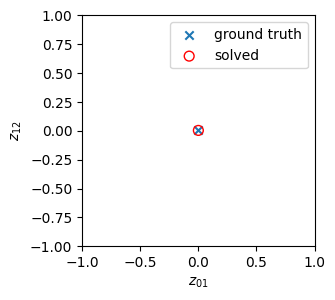

In [188]:
fig, ax1 = plt.subplots(ncols=1, figsize=(3, 3), sharey = True)

ax1.scatter([z_star[0]], [z_star[1]], marker='x', label='ground truth')
ax1.scatter([z_solution[0]], [z_solution[1]], marker='o',
            facecolors='none', edgecolors='red', s=50, label='solved')
ax1.set_xlabel(r'$z_{01}$')
ax1.set_ylabel(r'$z_{12}$')
ax1.set_ylim(-1, 1)
ax1.set_xlim(-1, 1)
ax1.legend()
plt.show()

In [189]:
z_solution.shape

(113,)

In [190]:
p_max = Pmax.reshape(-1, 1)
p_min = Pmin.reshape(-1, 1)
q_max = Qmax.reshape(-1, 1)
q_min = Qmin.reshape(-1, 1)

p_solution = p_in_transformed_space(z_solution)
q_solution = q_in_transformed_space(z_solution)


bus_types = np.array(bus_types).reshape(-1, 1)

results = np.concatenate([bus_types, p_max, p_solution, p_min, q_max, q_solution, q_min], axis=1)
column_names = ['bus_types', 'p_max', 'p_solution', 'p_min', 'q_max', 'q_solution', 'q_min']
results_df = pd.DataFrame(results, columns=column_names)
print(results_df)

    bus_types                 p_max            p_solution  p_min  q_max  \
0        load                1.0622    1.0594361738164935  -10.0   10.0   
1        load               -0.0882  -0.09197329026071088  -10.0   10.0   
2        load                0.0157  0.012285718637656373  -10.0   10.0   
3        load               -0.1961  -0.19949465545406042  -10.0   10.0   
4        load  -0.08990000000000001  -0.09354700625456758  -10.0   10.0   
..        ...                   ...                   ...    ...    ...   
109      load  0.021400000000000002  0.011492630467216713  -10.0   10.0   
110      load  -0.09150000000000001  -0.10150536072011107  -10.0   10.0   
111      load               -0.1003    -0.111441378807001  -10.0   10.0   
112      load               -0.1846   -0.1930808147780283  -10.0   10.0   
113     slack                200.01    30.372259769754606    0.0  200.0   

                q_solution                q_min  
0        4.031581907262989                 0.19  

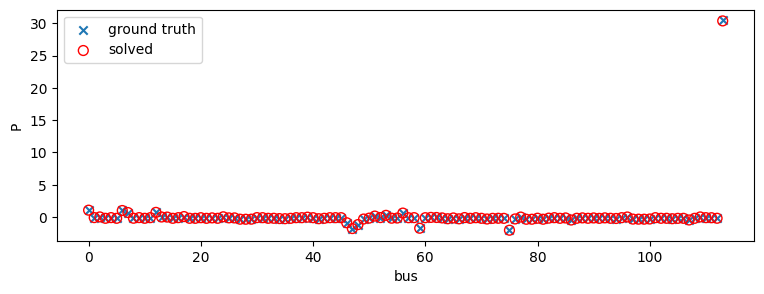

In [191]:
fig, ax1 = plt.subplots(ncols=1, figsize=(9, 3), sharey = True)

ax1.scatter(range(num_nodes), np.squeeze(p_star ), marker='x', label='ground truth')
ax1.scatter(range(num_nodes), np.squeeze(p_solution ), marker='o',
            facecolors='none', edgecolors='red', s=50, label='solved')
ax1.set_xlabel('bus')
ax1.set_ylabel('P')
ax1.legend()
plt.show()

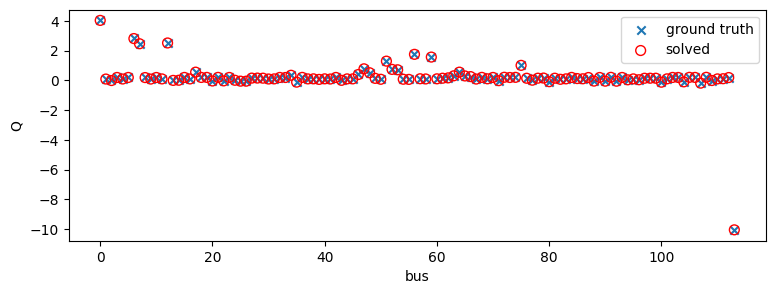

In [192]:
fig, ax1 = plt.subplots(ncols=1, figsize=(9, 3), sharey = True)

ax1.scatter(range(num_nodes), np.squeeze(q_star ), marker='x', label='ground truth')
ax1.scatter(range(num_nodes), np.squeeze(q_solution ), marker='o',
            facecolors='none', edgecolors='red', s=50, label='solved')
ax1.set_xlabel('bus')
ax1.set_ylabel('Q')
ax1.legend()
plt.show()

In [193]:
# np.save(se_proposed_path + 'iter3_z_solution.npy', z_solution)